<a href="https://colab.research.google.com/github/luisam19/course_optimizacion/blob/main/Taller_PE_LuisaMariaZapataSaldarriaga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='056938'> **Requerimientos iniciales -** </font> </font> <font color='8EC044'> **Instalación de librerias** </font>

In [ ]:
!pip install pyomo
!pip install highspy # Agregué un nuevo solver
!apt-get install -y -qq glpk-utils

In [ ]:
import numpy as np
import random as rand
rand.seed(10)

import pyomo.environ as pyo
# solver = pyo.SolverFactory('glpk')
solver = pyo.SolverFactory('appsi_highs') # activé el nuevo solver

# <font color='056938'> **Problemas de corte y enmpaquetamiento  en dos dimensiones**  </font>



Los problemas de corte (*cut*) y empaquetamiento (*packing*) bidimensionales (rectangulares) modelan una gran cantidad de aplicaciones industriales relevantes. En la primera clase de problemas, un conjunto de objetos rectangulares debe ser cortado de un conjunto de unidades de láminas rectangulares, mientras que en la segunda clase, un conjunto de objetos rectangulares debe ser embalado en un conjunto de contenedores rectangulares. Los dos problemas están fuertemente relacionados, en el sentido de que cortar un objeto de una unidad de stock es prácticamente equivalente a embalar un objeto en un contenedor.

Consideraremos la variante más estudiada de estos problemas, donde los bordes de los objetos deben ser paralelos a los de la láminas  (corte y embalaje rectangulares ortogonales). Sea $L = (W, H)$ una lámina  rectangular de ancho $W ∈ Z^+$ y alto $H ∈ Z^+$, e $I$ un conjunto de piezas rectangulares, donde cada pieza $i ∈ I$ tiene un ancho $w_i ∈ Z^+$ y una altura $h_i ∈ Z^+$ (con $w_i ≤ W$ y $h_i ≤ H$). Un corte de $I' ⊆ I$ en $L$ se puede describir como una función $F: I' → Z^2_+$ que asigna a cada objeto $i ∈ I'$ un par de coordenadas $F(i) = (x_i, y_i)$, tal que:
>  $x_i ∈ {0, . . . , W − wi }$ y $y_i ∈ {0, . . . , H − hi }$ para $i ∈ I'$

>$[x_i, x_i + w_i) ∩ [x_j, x_j + w_j) = ∅$  ó $[y_i, y_i + h_i) ∩ [y_j, y_j + h_j) = ∅ $ para  $i, j ∈ I', i ≠ j$.


En esta representación, la lámina se encuentra en un plano cartesiano con sus bordes paralelos a los ejes y su esquina inferior izquierda en el origen. Las coordenadas $F(i) = (x_i, y_i)$ representan la posición donde se coloca la esquina inferior izquierda de cada $i ∈ I$. Las restricciones (1) imponen que cada elemento esté completamente dentro del contenedor, mientras que las restricciones (2) prohíben la superposición entre pares de elementos. Las restricciones (1) y (2) imponen que los elementos tengan una orientación fija (es decir, no se pueden rotar).



## <font color='8EC044'> **2D-CSP:** </font> <font color='056938'> **Problema de corte en dos dimensiones** </font>

De manera particular, el problema de corte bidimensional (2D-CSP) puede definirse como:
> Dado un número ilimitado de láminas idénticas y un conjunto $I$ de elementos, donde cada elemento está asociado con una demanda $d_i ∈ Z^+$ (el número mínimo de copias a ser cortadas), determinar el número mínimo de láminas necesarias para cortar todas las demandas.

El Problema de empaquetado de contenedores bidimensional (**2D-BPP**) es el caso especial en el que $d_i = 1$, para todo $i ∈ I$.


### <font color='8EC044'> **Instancia de prueba** </font>

Usaremos algunas de las instancias del problema descritas en `2DPackLib`  (Iori, M., et al, 2022), las cuales siguen la siguiente estructura:



```
m
W H
i w_i h_i d_i b_i p_i (for each i=1,...,m)
```

Dónde:

| Variable | Descripción                                     |
|----------|-------------------------------------------------|
| m        | Número de elementos                             |
| W        | Ancho de la lámina                            |
| H        | Altura de la lámina  |
| i        | ID del elemento                                 |
|$w_i$      | Ancho del elemento i                            |
| $h_i$      | Altura del elemento i                           |
| $d_i$      | Demanda del elemento i (número mínimo de copias)|
| $b_i$      | Número máximo de copias del elemento i         |
| $p_i$      | Ganancia del elemento i                         |

Los dos ultimos elementos ($b_i$ y $p_i$) no son de relevancia para nuestro caso


La siguiente linea de código carga las instancaias `[A2.ins2D, A10.ins2D, A15.ins2D, A18.ins2D, A25.ins2D] `

In [ ]:
!gdown 19wYHUwIPlcwX7CypH1ArphAQFmKrUJi3
!gdown 1Gqnq6iHY5zWwvJkeHrpk0ycJ0g_hloz2
!gdown 1lQ3S-HJ-fhnsT50-KMtT8VbYTrlhwDd_
!gdown 12iMi0IrBUh-ALyhY3_HNzZA5WqI855xH
!gdown 1nq2bfzGawhG4WtpjvUXxIgrl50JUQqVH

Por su parte, la siguiente función carga los datos la instancia identificada por su `name`

In [ ]:
def read_data(name):
  with open(name, 'r') as file:
    orders = []
    for line in file:
        row = [int(value) for value in line.split()]
        orders.append(row[:4])
    m = orders.pop(0)[0]
    roll = orders.pop(0)
    W = roll[0]
    H = roll[1]

  return m, W, H, orders

Por ejemplo, leeremos los datos de la instancia `A15.ins2D`

In [ ]:
m, W, H, orders = read_data("A18.ins2D")
print(f'La instancia considera cortar piezas de {m} diferentes tamaños diferentes usando láminas de ancho {W} y altura {H}')
orders


In [ ]:
(2357*935*28+2117*775*8+303*486+ 303*386)/2750*1220

## <font color='8EC044'> **Punto 1:** </font> <font color='056938'> **Formulación** </font>

* Proponga una formulación matemática del problema descrito
* Describa los *pro* y *contras* del modelo propuesto  
* Implemente el modelo propuesto y utilicelo para dar solución a algunas de las instancias descargadas.

# The two-dimensional bin packing problem with variable bin sizes and costs

### Conjuntos
- $I = \{1, \ldots, n\} $: Conjunto de ítems rectangulares.
- $K = \{1, \ldots, m\} $: Conjunto de tipos de lámina disponibles.

### Variables de Decisión
- $l_{i,j} $: Variable binaria que vale 1 si el ítem $i$ está a la izquierda del ítem $j$.
- $b_{ij} $: Variable binaria que vale 1 si el ítem $i$ está debajo del ítem $j$.
- $f_{ik} $: Variable binaria que vale 1 si el ítem $i$ está ubicado en el contenedor tipo $k$.
- $z_k $: Variable binaria que vale 1 si se utiliza al menos un contenedor tipo $k$.
- $(x_i, y_i) $: Coordenadas de la esquina inferior izquierda del ítem $i$.

### Parámetros
- $w_i$: Ancho del ítem $i$.
- $h_i$: Altura del ítem $i$.
- $W$: Ancho del contenedor
- $H$: Altura del contenedor

### Formulación del Modelo
El objetivo es minimizar el costo total de los laminaes utilizados:

$
\min \sum_{k=1}^m z_k
$

Sujeto a las siguientes restricciones:

1. **Restricción de no superposición:**

   $
   l_{i,j} + l_{j,i} + b_{ij} + b_{ji} + (1 - f_{ik}) + (1 - f_{jk}) \geq 1, \quad \forall i, j \in R, \, i < j, \, k \in K
   $

2. **Ubicación relativa de los ítems:**

   $x_i- x_j + Wl_ij <= W - w_i $
   $
  y_i- y_j + Wb_ij <= H - h_i
   $

3. **No exceder los límites del lamina:**

   $
   x_i <= W_k -w_i + (1-f_ik) W
   $
   
   $
   Y_i <= H_k -h_i + (1-f_ik) H
   $

4. **Cada ítem debe ser colocado en algún lamina:**

   $
   \sum_{k=1}^m f_{ik} >= 1, \quad \forall i \in R
   $

5. **Uso de los laminaes:**

   $
    f_{ik} \leq z_k, \quad \forall k \in K
   $

### Condiciones sobre las Variables

- $i_{j}, b_{ij} \in \{0, 1\}, \quad \forall i, j \in R $
- $f_{ik} \in \{0, 1\}, \quad \forall i \in R, \, k \in K $
- $x_i, y_i \geq 0, \quad \forall i \in R $
- $z_k \in \{0, 1\}, \quad \forall k \in K $

Con esta formulación se busca empaquetar todos los ítems en los laminaes disponibles de manera que el costo total sea mínimo, respetando las restricciones de no superposición y los límites de los laminaes.

### **pros**

- La utilización de coordenadas para la esquina inferior izquierda de cada ítem permite un control preciso sobre la ubicación de cada uno dentro de los contenedores.
- La inclusión de múltiples tipos de láminas con diferentes tamaños y costos proporciona flexibilidad, permitiendo una mejor adaptación a las necesidades específicas del problema.
- El modelo está diseñado para minimizar el costo total de los láminas utilizados, lo que puede ser particularmente beneficioso en industrias donde los costos de materiales son altos.

### **contras**

- El modelo involucra muchas variables binarias y continuas, lo que puede hacer que la resolución del problema sea computacionalmente intensiva, especialmente para grandes conjuntos de ítems y contenedores.
- La eficiencia del modelo depende en gran medida de la precisión de los parámetros de entrada, como dimensiones de los ítems y contenedores, así como los costos asociados.
- Las restricciones sobre la ubicación relativa de los ítems pueden ser demasiado restrictivas en algunos casos, limitando las soluciones posibles y potencialmente incrementando el tiempo de cómputo.

In [ ]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, RangeSet, Binary, NonNegativeReals

def create_model(m, W, H, orders):
    model = ConcreteModel()

    # Conjuntos
    n = len(orders)
    # model.I = RangeSet(1, n)
    # model.K = RangeSet(1, 50)

    pieces = []
    for order in orders:
        for _ in range(order[3]):  # order[3] es la demanda
            pieces.append((order[1], order[2]))  # order[1] es el ancho, order[2] es el alto

    num_pieces = len(pieces)  # Total number of pieces to place
    items = range(1, num_pieces + 1)
    sheets = range(1, num_pieces + 1)

    # Parámetros
    model.I = RangeSet(1, num_pieces )
    model.K = RangeSet(1, num_pieces )

    model.w = {i: pieces[i-1][0] for i in model.I}
    model.h = {i: pieces[i-1][1] for i in model.I}
    model.W = W
    model.H = H

    # Variables de decisión
    model.x = Var(model.I, domain=NonNegativeReals)
    model.y = Var(model.I, domain=NonNegativeReals)
    model.z = Var(model.K, domain=Binary)
    model.l = Var(model.I, model.I, domain=Binary)
    model.b = Var(model.I, model.I, domain=Binary)
    model.f = Var(model.I, model.K, domain=Binary)

    # Función objetivo
    def objective_rule(model):
        return sum(model.z[k] for k in model.K)
    model.obj = Objective(rule=objective_rule, sense='minimize')

    # Restricciones

    #No superposición
    def no_overlap_rule(model, i, j, k):
      if i < j:
          return model.l[i, j] + model.l[j, i] + model.b[i, j] + model.b[j, i] + (1 - model.f[i, k]) + (1 - model.f[j, k]) >= 1
      else:
          return Constraint.Skip  # Omite la restricción cuando i >= j
    model.no_overlap_constraint = Constraint(model.I, model.I, model.K, rule=no_overlap_rule)

    def relative_position_x_rule(model, i, j, k):
      return model.x[i] - model.x[j] +model.l[i, j]*model.W <= model.W - model.w[i]
    model.relative_position_x_constraint = Constraint(model.I, model.I, model.K, rule=relative_position_x_rule)

    def relative_position_y_rule(model, i, j, k):
      return model.y[i] - model.y[j] + model.H*model.b[i, j] <= model.H  - model.h[i]
    model.relative_position_y_constraint = Constraint(model.I, model.I, model.K, rule=relative_position_y_rule)

    def inside_bin_x_rule(model, i, k):
      return model.x[i] <= model.W- model.w[i] + (1 - model.f[i, k]) * model.W
    model.inside_bin_x_constraint = Constraint(model.I, model.K, rule=inside_bin_x_rule)

    def inside_bin_y_rule(model, i, k):
      return model.y[i] <=  model.H - model.h[i] + (1 - model.f[i, k]) * model.H
    model.inside_bin_y_constraint = Constraint(model.I, model.K, rule=inside_bin_y_rule)

    def each_item_in_one_bin_rule(model, i):
      return sum(model.f[i, k] for k in model.K) >= 1
    model.each_item_in_one_bin_constraint = Constraint(model.I, rule=each_item_in_one_bin_rule)

    def bin_used_if_any_item_in_it_rule(model,i, k):
        return model.f[i, k] <= model.z[k]
    model.bin_used_if_any_item_in_it_constraint = Constraint(model.I,model.K, rule=bin_used_if_any_item_in_it_rule)

    return model


**Agrueé esta linea de solución**

In [ ]:
m, W, H, orders = read_data("A2.ins2D")
model = create_model(m, W, H, orders)
solver = SolverFactory('appsi_highs')
log = solver.solve(model, tee=True)


## <font color='8EC044'> **Punto 2:** </font> <font color='056938'> **Relajaciones y cotas duales** </font>

* Describa un procedimiento para obtener cotas duales (inferiores) para el número total de láminas requeridas

#### **Relajación Continua del Problema Original**

- Relajar las variables binarias $𝑓_𝑖𝑘$ para que sean continuas en el intervalo [0, 1].

- Resolver este problema relajado con un solver de programación lineal para obtener una solución fraccional.

- El valor objetivo de esta solución fraccional proporciona una cota inferior para el problema binario original, ya que permite fraccionar los ítems entre diferentes láminas.

### **cota inferior de área**

* Calcular la cota inferior basada en el área total de los ítems y la capacidad de los contenedores.

La cota inferior sería
$\left\lceil \frac{\sum_{i \in I} (w_i \cdot h_i)}{W \cdot H} \right\rceil$
donde
$\sum_{i \in I} (w_i \cdot h_i)
$
es el área total de los ítems y $W \cdot H$
es el área de un contenedor.

* Calcule el valor de la cota para cada una de las instancias descargadas

Para instancias muy grandes se demora mucho en ejecución, por tanto se procede a realizar la instancia A2 y A10 que son las más pequeñas, el tiempo de ejecución es más rápida cuando se hace el primer  caso de relajación continua que cuando se utiliza la cota construida del área.

In [ ]:
m, W, H, orders = read_data("A2.ins2D")
model = create_model(m, W, H, orders)
solver = SolverFactory('appsi_highs')
log = solver.solve(model, tee=True)
for i in model.I:
    for k in model.K:
        model.f[i, k].domain = NonNegativeReals
# Resolver el modelo
solver = SolverFactory('appsi_highs')
log = solver.solve(model, tee=True)

In [ ]:
instancias= ['A2.ins2D', 'A10.ins2D', 'A15.ins2D','A18.ins2D','A25.ins2D']
def calcular_cota_inferior_area(orders, W, H):
    total_area = sum(order[1] * order[2] * order[3] for order in orders)
    container_area = W * H
    return (total_area + container_area - 1) // container_area  # Redondeo hacia arriba

m, W, H, orders = read_data(instancias[0])
cota_inferior_area = calcular_cota_inferior_area(orders, W, H)

print(f"Cota inferior de área: {cota_inferior_area}")

# Añadir la restricción de cota inferior de área
def lower_bound_bins_rule(model):
    return sum(model.z[k] for k in model.K) <= cota_inferior_area
model.lower_bound_bins_constraint = Constraint(rule=lower_bound_bins_rule)

solver = SolverFactory('appsi_highs')
log = solver.solve(model, tee=True)


## <font color='8EC044'> **Punto 3:** </font> <font color='056938'> **Cotas primales y soluciones fáctibles** </font>

* Describa un procedimiento para obtener cotas primales (superiores) para el número total de láminas requeridas

La heurística de mejor ajuste (Best Fit) es un enfoque utilizado en el problema de empaquetamiento que busca colocar los ítems en los contenedores de manera que se minimice el espacio sobrante en cada contenedor después de colocar todos los ítems posibles.

1. Inicializa una lista de contenedores vacíos.
2. Ordena los ítems de acuerdo a algún criterio, como el área (ancho por alto) de los ítems de manera descendente. Esto permite comenzar con los ítems más grandes, lo que puede facilitar el empaquetamiento.
3. Para cada ítem en la lista ordenada:
  * Itera sobre todos los contenedores disponibles.
  * Calcula el espacio sobrante en cada contenedor después de colocar el ítem
  * Selecciona el contenedor con el menor espacio sobrante que aún puede contener el ítem.
  * Coloca el ítem en el contenedor seleccionado y actualiza el espacio sobrante del contenedor.
4. Si ningún contenedor puede contener el ítem actual, crea un nuevo contenedor y coloca el ítem en él.


* Calcule el valor de la cota para las instancias descargadas

Al igual que en el caso anterior cuando ejecuto instancias muy grandes el tiempo de ejecución aumenta demasiado por tanto se procede hacer prueba unicamente en las dos primeras instancias.

In [ ]:
from operator import itemgetter

def best_fit_heuristic(model):
    # Ordena los ítems por área (ancho * alto) de manera descendente
    sorted_items = sorted(model.I, key=lambda i: model.w[i] * model.h[i], reverse=True)

    # Lista de contenedores inicialmente vacíos
    containers = []

    # Define una clase para representar los contenedores
    class Container:
        def __init__(self, width, height):
            self.items = []
            self.width = width
            self.height = height

        # Calcula el espacio sobrante en el contenedor después de colocar un ítem
        def space_left(self, model, item):
            item_width = model.w[item]
            item_height = model.h[item]
            return self.width * self.height - sum(model.w[i] * model.h[i] for i in self.items) - item_width * item_height

        # Coloca un ítem en el contenedor y actualiza el espacio sobrante
        def place_item(self, model, item):
            self.items.append(item)

    # Para cada ítem en la lista ordenada
    for item in sorted_items:
        # Inicializa el mejor contenedor encontrado hasta ahora y su espacio sobrante
        best_container = None
        best_space_left = float('inf')

        # Itera sobre todos los contenedores disponibles
        for container in containers:
            # Calcula el espacio sobrante en el contenedor después de colocar el ítem
            space_left = container.space_left(model, item)

            # Si el espacio sobrante es el mejor encontrado hasta ahora y el ítem cabe en el contenedor
            if space_left >= 0 and space_left < best_space_left:
                best_container = container
                best_space_left = space_left

        # Si se encontró un contenedor adecuado
        if best_container is not None:
            # Coloca el ítem en el mejor contenedor encontrado
            best_container.place_item(model, item)
        else:
            # Crea un nuevo contenedor y coloca el ítem en él
            new_container = Container(model.W, model.H)  # Pasa W y H como parámetros al crear un nuevo contenedor
            new_container.place_item(model, item)
            containers.append(new_container)

    # Devuelve el número total de contenedores utilizados y la distribución de ítems en cada contenedor
    return len(containers), [(container.items, container.space_left) for container in containers]


In [ ]:

m, W, H, orders = read_data(instancias[0])
model = create_model(m, W, H, orders)
# Llama a la heurística de mejor ajuste y obtén el resultado
num_containers, container_contents = best_fit_heuristic(model)

# Imprime el resultado
print("Número total de contenedores utilizados:", num_containers)
for i, (items, space_left) in enumerate(container_contents, start=1):
    print("Contenedor", i, ": ítems =", items)


In [ ]:

m, W, H, orders = read_data(instancias[1])
model = create_model(m, W, H, orders)
# Llama a la heurística de mejor ajuste y obtén el resultado
num_containers, container_contents = best_fit_heuristic(model)

# Imprime el resultado
print("Número total de contenedores utilizados:", num_containers)
for i, (items, space_left) in enumerate(container_contents, start=1):
    print("Contenedor", i, ": ítems =", items)

# <font color='056938'> **Referencias y webgrafia** </font>


* Iori, M., de Lima, V. L., Martello, S., & Monaci, M. (2022). 2DPackLib: a two-dimensional cutting and packing library. Optimization Letters, 1-10.

* Costa, G., Delorme, M., Iori, M., Malaguti, E., & Martello, S. (2017). Training software for orthogonal packing problems. Computers & Industrial Engineering, 111, 139-147.

* Lodi, A. (1999). Algorithms for two-dimensional bin packing and assignment problems. Doktorarbeit, DEIS, Universita di Bologna, 16. [Chapter 2](https://drive.google.com/file/d/1fGBf86rprlg1UM8IlaMV36CPvleL0YAS/view?usp=sharing)

* https://github.com/secnot/rectpack
* https://emadehsan.com/csp/
* https://www.opticutter.com/cut-list-optimizer
* https://www.cutlistoptimizer.com/

## Artículos consultados

* https://core.ac.uk/download/pdf/82070195.pdf
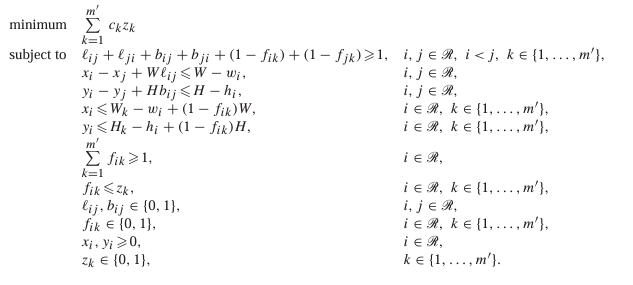
* http://www.scielo.org.co/pdf/rfiua/n46/n46a12.pdf
* https://drive.google.com/file/d/1fGBf86rprlg1UM8IlaMV36CPvleL0YAS/view
* https://repositorio.uam.es/bitstream/handle/10486/698396/luque_lopez_miguel_angel_tfg.pdf?sequence=1
* https://www.intechopen.com/chapters/69492
* https://link.springer.com/article/10.1007/s11590-021-01808-y
* https://www.semanticscholar.org/paper/Heuristic-and-Metaheuristic-Approaches-for-a-Class-Lodi-Martello/aa9d753131a76ce23a95ba246fb3c13e43c010f6
* https://www.intechopen.com/chapters/69492